# Step 0.1. Import necessary libraries 

In [17]:
# Standard python libraries
import logging
import os
import time
import requests
logging.basicConfig(format='[%(asctime)s] (%(levelname)s): %(message)s', level=logging.INFO)

# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch

from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error
import typing

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.dataset.roles import DatetimeRole

In [18]:
THRESHOLD = 0.15
NEGATIVE_WEIGHT = 1.1

# Step 0.3. Data load 

In [2]:
%%time

train_data = pd.read_csv('./data/train.csv')
train_data.head()

[2021-09-24 22:36:13,262] (WARNING): <decorator-gen-54>:2: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.



CPU times: user 1.17 s, sys: 76.6 ms, total: 1.24 s
Wall time: 1.26 s


,city,floor,id,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,...,reform_mean_floor_count_1000,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,date,realty_type,price_type
0,Пермь,NaN,COL_0,57.998207,56.292797,4,19,35,52,0,...,5.762963,5.530612,1964.118519,1960.959184,Пермский край,32.0,S27289,2020-01-05,10,0
1,Шатура,NaN,COL_1,55.574284,39.543835,3,24,37,59,0,...,2.894366,3.527778,1952.321678,1957.222222,Московская область,280.0,S17052,2020-01-05,10,0
2,Ярославль,NaN,COL_2,57.619140,39.850525,1,30,67,128,0,...,6.141414,7.222222,1968.150000,1973.370370,Ярославская область,297.4,S16913,2020-01-05,110,0
3,Новокузнецк,NaN,COL_3,53.897083,87.108604,0,0,5,21,0,...,8.581081,9.000000,1992.716216,2014.000000,Кемеровская область,190.0,S10148,2020-01-05,110,0
4,Москва,NaN,COL_4,55.802590,37.487110,1,23,64,153,0,...,7.263889,5.684211,1963.229167,1960.500000,Москва,60.2,S1338,2020-01-05,10,0


In [3]:
test_data = pd.read_csv('./data/test.csv')
test_data.head()

,city,floor,id,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,osm_building_points_in_0.005,osm_building_points_in_0.0075,...,reform_mean_year_building_1000,reform_mean_year_building_500,region,lat,lng,total_square,street,date,realty_type,price_type
0,Курск,1.0,COL_289284,7,55,85,117,0,0,0,...,1966.471591,1966.740260,Курская область,51.709255,36.147908,156.148996,S6983,2020-09-06,100,1
1,Сургут,1.0,COL_289305,8,70,112,140,0,0,0,...,1988.259259,1989.068182,Ханты-Мансийский АО,61.233240,73.462509,190.737943,S29120,2020-09-06,110,1
2,Тюмень,-1.0,COL_289318,3,28,67,122,0,0,0,...,1985.880282,1991.458333,Тюменская область,57.143110,65.554573,457.118051,S23731,2020-09-06,10,1
3,Иркутск,1.0,COL_289354,5,76,139,231,0,0,0,...,1947.073276,1941.657895,Иркутская область,52.281380,104.282975,66.503622,S14207,2020-09-06,100,1
4,Курск,NaN,COL_289399,8,105,189,279,0,0,2,...,1948.764151,1946.689655,Курская область,51.729706,36.194019,23.864915,S20658,2020-09-06,10,1


In [4]:
submission = pd.read_csv('./data/test_submission.csv')
submission.head()

,id,per_square_meter_price
0,COL_289284,0
1,COL_289305,0
2,COL_289318,0
3,COL_289354,0
4,COL_289399,0


In [6]:
print(train_data.shape)
print(test_data.shape)

(279792, 77)
(2974, 76)


In [26]:
print(train_data.columns)

Index(['city', 'floor', 'id', 'lat', 'lng', 'osm_amenity_points_in_0.001',
       'osm_amenity_points_in_0.005', 'osm_amenity_points_in_0.0075',
       'osm_amenity_points_in_0.01', 'osm_building_points_in_0.001',
       'osm_building_points_in_0.005', 'osm_building_points_in_0.0075',
       'osm_building_points_in_0.01', 'osm_catering_points_in_0.001',
       'osm_catering_points_in_0.005', 'osm_catering_points_in_0.0075',
       'osm_catering_points_in_0.01', 'osm_city_closest_dist',
       'osm_city_nearest_name', 'osm_city_nearest_population',
       'osm_crossing_closest_dist', 'osm_crossing_points_in_0.001',
       'osm_crossing_points_in_0.005', 'osm_crossing_points_in_0.0075',
       'osm_crossing_points_in_0.01', 'osm_culture_points_in_0.001',
       'osm_culture_points_in_0.005', 'osm_culture_points_in_0.0075',
       'osm_culture_points_in_0.01', 'osm_finance_points_in_0.001',
       'osm_finance_points_in_0.005', 'osm_finance_points_in_0.0075',
       'osm_finance_points_in

# Step 0.2. Parameters 

In [32]:
N_THREADS = 16 # threads cnt for lgbm and linear models
N_FOLDS = 7 # folds cnt for AutoML, best 7
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.1 # Test size for metric check
TIMEOUT = 3*3600 # Time in seconds for automl run
TARGET_NAME = 'per_square_meter_price' # Target column name

# Step 0.4. Some user feature preparation 

In [11]:
def deviation_metric_one_sample(y_true: typing.Union[float, int], y_pred: typing.Union[float, int]) -> float:
    """
    Реализация кастомной метрики для хакатона.

    :param y_true: float, реальная цена
    :param y_pred: float, предсказанная цена
    :return: float, значение метрики
    """
    deviation = (y_pred - y_true) / np.maximum(1e-8, y_true)
    if np.abs(deviation) <= THRESHOLD:
        return 0
    elif deviation <= - 4 * THRESHOLD:
        return 9 * NEGATIVE_WEIGHT
    elif deviation < -THRESHOLD:
        return NEGATIVE_WEIGHT * ((deviation / THRESHOLD) + 1) ** 2
    elif deviation < 4 * THRESHOLD:
        return ((deviation / THRESHOLD) - 1) ** 2
    else:
        return 9


def deviation_metric(y_true: np.array, y_pred: np.array) -> float:
    return np.array([deviation_metric_one_sample(y_true[n], y_pred[n]) for n in range(len(y_true))]).mean()

def median_absolute_percentage_error(y_true: np.array, y_pred: np.array) -> float:
    return np.median(np.abs(y_pred-y_true)/y_true)

# ========= AutoML preset usage =========


## Step 1. Create Task

In [33]:
%%time

task = Task('reg', loss='mse', metric=deviation_metric, greater_is_better=False)

CPU times: user 197 µs, sys: 106 µs, total: 303 µs
Wall time: 312 µs


## Step 2. Setup columns roles

Roles setup here set target column and base date, which is used to calculate date differences:

In [34]:
%%time

roles = {'target': TARGET_NAME,
         'drop': ['id', 'floor'],
         DatetimeRole(base_date=False, base_feats=True, seasonality=('y', 'm', 'd')): 'date'
         }

CPU times: user 51 µs, sys: 0 ns, total: 51 µs
Wall time: 57.7 µs


## Step 3. Create AutoML from preset

To create AutoML model here we use `TabularAutoML` preset, which looks like:

![TabularAutoML preset pipeline](https://github.com/sberbank-ai-lab/LightAutoML/raw/master/imgs/tutorial_2_pipeline.png)

All params we set above can be send inside preset to change its configuration:

In [35]:
%%time 

automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params = {'use_algos': [['lgb_tuned', 'lgb','cd']]},
                       tuning_params = {'fit_on_holdout':True, 'max_tuning_iter': 201, 'max_tuning_time': 500},
                       lgb_params = {'default_params': {'num_threads': N_THREADS}},
                       cb_params = {'default_params':{'task_type': "GPU"}}
                      )
oof_pred = automl.fit_predict(train_data.drop('date', axis=1), roles = roles)
logging.info('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

Start automl preset with listed constraints:
- time: 10800 seconds
- cpus: 16 cores
- memory: 16 gb

Train data shape: (279792, 76)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 10788.811262845993 secs
Start fitting Selector_LightGBM ...

===== Start working with fold 0 for Selector_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 8.07171e+09	valid's Opt metric: 3.93613
[200]	valid's l2: 7.21632e+09	valid's Opt metric: 3.69503
[300]	valid's l2: 6.82605e+09	valid's Opt metric: 3.6216
[400]	valid's l2: 6.55875e+09	valid's Opt metric: 3.55427
[500]	valid's l2: 6.35313e+09	valid's Opt metric: 3.49941
[600]	valid's l2: 6.20533e+09	valid's Opt metric: 3.46235
[700]	valid's l2: 6.07268e+09	valid's Opt metric: 3.42871
[800]	valid's l2: 5.97092e+09	valid's Opt metric: 3.39761
[900]	valid's l2: 5.87914e+09	valid's Opt metric: 3.36882
[1000]	valid's l2: 5.80959e+09	valid's Opt metric: 3.34742
[1100]	

[2021-09-25 00:25:55,625] (INFO): A new study created in memory with name: no-name-8ae095ed-1271-4d6b-bd5a-fb1adb456237


Start fitting Lvl_0_Pipe_0_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 6.0209e+09	valid's Opt metric: 3.15837
[200]	valid's l2: 5.77223e+09	valid's Opt metric: 3.06588
Early stopping, best iteration is:
[179]	valid's l2: 5.78918e+09	valid's Opt metric: 3.03203
Lvl_0_Pipe_0_Mod_1_LightGBM fitting and predicting completed


[2021-09-25 00:26:41,413] (INFO): Trial 0 finished with value: -3.0320256333628284 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -3.0320256333628284.


Start fitting Lvl_0_Pipe_0_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 6.26231e+09	valid's Opt metric: 3.16001
[200]	valid's l2: 5.90806e+09	valid's Opt metric: 3.03964
Early stopping, best iteration is:
[182]	valid's l2: 5.93473e+09	valid's Opt metric: 3.02933
Lvl_0_Pipe_0_Mod_1_LightGBM fitting and predicting completed


[2021-09-25 00:27:25,848] (INFO): Trial 1 finished with value: -3.029328643801239 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285}. Best is trial 1 with value: -3.029328643801239.


Start fitting Lvl_0_Pipe_0_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 6.48199e+09	valid's Opt metric: 3.20782
[200]	valid's l2: 6.22239e+09	valid's Opt metric: 3.05421
[300]	valid's l2: 6.117e+09	valid's Opt metric: 3.02978
[400]	valid's l2: 6.05664e+09	valid's Opt metric: 3.06535
Early stopping, best iteration is:
[305]	valid's l2: 6.11435e+09	valid's Opt metric: 3.02782
Lvl_0_Pipe_0_Mod_1_LightGBM fitting and predicting completed


[2021-09-25 00:28:26,818] (INFO): Trial 2 finished with value: -3.0278154108345094 and parameters: {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 2 with value: -3.0278154108345094.


Start fitting Lvl_0_Pipe_0_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 6.37456e+09	valid's Opt metric: 3.19982
[200]	valid's l2: 6.09537e+09	valid's Opt metric: 3.0651
[300]	valid's l2: 5.96996e+09	valid's Opt metric: 3.04503
[400]	valid's l2: 5.90958e+09	valid's Opt metric: 3.07636
Early stopping, best iteration is:
[311]	valid's l2: 5.96023e+09	valid's Opt metric: 3.04143
Lvl_0_Pipe_0_Mod_1_LightGBM fitting and predicting completed


[2021-09-25 00:29:30,272] (INFO): Trial 3 finished with value: -3.0414326724753757 and parameters: {'feature_fraction': 0.7159725093210578, 'num_leaves': 85, 'bagging_fraction': 0.8059264473611898, 'min_sum_hessian_in_leaf': 0.003613894271216527, 'reg_alpha': 4.258943089524393e-06, 'reg_lambda': 1.9826980964985924e-05}. Best is trial 2 with value: -3.0278154108345094.


Start fitting Lvl_0_Pipe_0_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 6.14609e+09	valid's Opt metric: 3.15298
[200]	valid's l2: 5.8553e+09	valid's Opt metric: 3.02151
[300]	valid's l2: 5.74721e+09	valid's Opt metric: 3.07415
Early stopping, best iteration is:
[229]	valid's l2: 5.79774e+09	valid's Opt metric: 3.0187
Lvl_0_Pipe_0_Mod_1_LightGBM fitting and predicting completed


[2021-09-25 00:30:24,549] (INFO): Trial 4 finished with value: -3.0187002173962485 and parameters: {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08}. Best is trial 4 with value: -3.0187002173962485.


Start fitting Lvl_0_Pipe_0_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 6.55683e+09	valid's Opt metric: 3.2226
[200]	valid's l2: 6.27152e+09	valid's Opt metric: 3.06369
[300]	valid's l2: 6.1571e+09	valid's Opt metric: 3.04241
Early stopping, best iteration is:
[299]	valid's l2: 6.1586e+09	valid's Opt metric: 3.04193
Lvl_0_Pipe_0_Mod_1_LightGBM fitting and predicting completed


[2021-09-25 00:31:23,320] (INFO): Trial 5 finished with value: -3.0419261671312303 and parameters: {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936}. Best is trial 4 with value: -3.0187002173962485.


Start fitting Lvl_0_Pipe_0_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 6.73811e+09	valid's Opt metric: 3.25931
[200]	valid's l2: 6.40565e+09	valid's Opt metric: 3.08405
[300]	valid's l2: 6.27717e+09	valid's Opt metric: 3.05116
[400]	valid's l2: 6.18722e+09	valid's Opt metric: 3.03944
[500]	valid's l2: 6.1215e+09	valid's Opt metric: 3.07657
Early stopping, best iteration is:
[410]	valid's l2: 6.17632e+09	valid's Opt metric: 3.03738
Lvl_0_Pipe_0_Mod_1_LightGBM fitting and predicting completed


[2021-09-25 00:32:38,757] (INFO): Trial 6 finished with value: -3.037383576682805 and parameters: {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026, 'reg_alpha': 1.254134495897175e-07, 'reg_lambda': 0.00028614897264046574}. Best is trial 4 with value: -3.0187002173962485.


Start fitting Lvl_0_Pipe_0_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 6.17123e+09	valid's Opt metric: 3.17918
[200]	valid's l2: 5.88083e+09	valid's Opt metric: 3.06886
[300]	valid's l2: 5.77306e+09	valid's Opt metric: 3.10323
Early stopping, best iteration is:
[221]	valid's l2: 5.84978e+09	valid's Opt metric: 3.06348
Lvl_0_Pipe_0_Mod_1_LightGBM fitting and predicting completed


[2021-09-25 00:33:30,001] (INFO): Trial 7 finished with value: -3.063483266530374 and parameters: {'feature_fraction': 0.5171942605576092, 'num_leaves': 234, 'bagging_fraction': 0.6293899908000085, 'min_sum_hessian_in_leaf': 0.4467752817973907, 'reg_alpha': 6.388511557344611e-06, 'reg_lambda': 0.0004793052550782129}. Best is trial 4 with value: -3.0187002173962485.


Start fitting Lvl_0_Pipe_0_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 6.53481e+09	valid's Opt metric: 3.2225
[200]	valid's l2: 6.26406e+09	valid's Opt metric: 3.06544
[300]	valid's l2: 6.14856e+09	valid's Opt metric: 3.07019
Early stopping, best iteration is:
[258]	valid's l2: 6.17468e+09	valid's Opt metric: 3.05365
Lvl_0_Pipe_0_Mod_1_LightGBM fitting and predicting completed


[2021-09-25 00:34:25,600] (INFO): Trial 8 finished with value: -3.053647878177893 and parameters: {'feature_fraction': 0.7733551396716398, 'num_leaves': 60, 'bagging_fraction': 0.9847923138822793, 'min_sum_hessian_in_leaf': 1.2604664585649468, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483}. Best is trial 4 with value: -3.0187002173962485.


Start fitting Lvl_0_Pipe_0_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 6.04526e+09	valid's Opt metric: 3.09045
[200]	valid's l2: 5.85284e+09	valid's Opt metric: 3.09141
Early stopping, best iteration is:
[149]	valid's l2: 5.90807e+09	valid's Opt metric: 3.04631

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 5.21718e+09	valid's Opt metric: 2.99445
[200]	valid's l2: 5.00691e+09	valid's Opt metric: 2.92528
[300]	valid's l2: 4.93369e+09	valid's Opt metric: 2.9007
[400]	valid's l2: 4.87865e+09	valid's Opt metric: 2.89801
[500]	valid's l2: 4.84589e+09	valid's Opt metric: 2.89391
Early stopping, best iteration is:
[451]	valid's l2: 4.85939e+09	valid's Opt metric: 2.89219

===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_1_LightGBM =====

Training until validati

[2021-09-25 00:46:36,734] (INFO): oof_pred:
array([[79965.55 ],
       [37541.926],
       [54479.492],
       ...,
       [73190.125],
       [76962.484],
       [55594.934]], dtype=float32)
Shape = (279792, 1)


CPU times: user 2h 29min 49s, sys: 2h 2min 44s, total: 4h 32min 33s
Wall time: 45min 45s


CPU times: user 113 ms, sys: 0 ns, total: 113 ms
Wall time: 119 ms


<AxesSubplot:xlabel='Feature'>

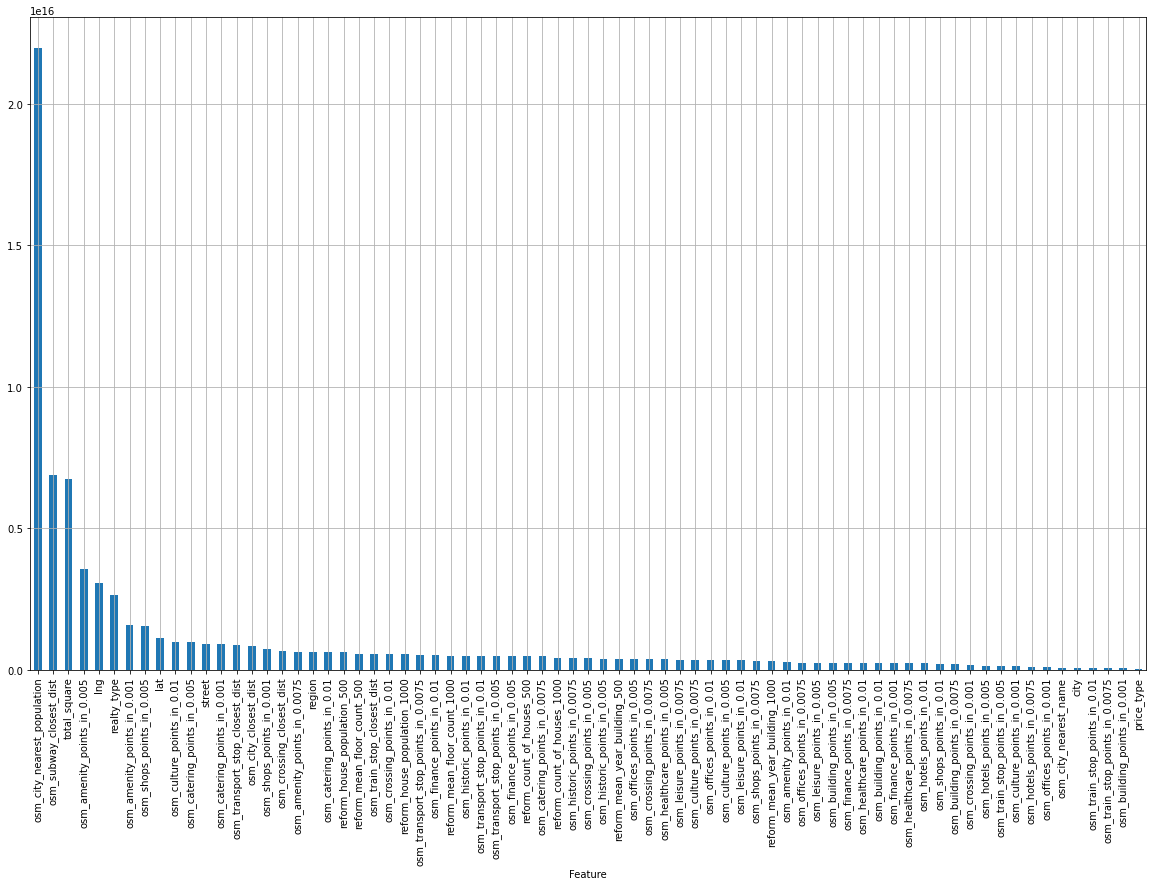

In [42]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 12), grid = True)

## Step 4. Predict to test data and check scores

In [37]:
%%time

test_pred = automl.predict(test_data)
logging.info('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

logging.info('Check scores...')
logging.info('OOF score: {}'.format(mean_absolute_error(train_data[TARGET_NAME].values, oof_pred.data[:, 0])))

[2021-09-25 00:48:24,039] (INFO): Prediction for test data:
array([[34850.305],
       [58194.52 ],
       [64421.79 ],
       ...,
       [61413.863],
       [31621.676],
       [56347.336]], dtype=float32)
Shape = (2974, 1)
[2021-09-25 00:48:24,040] (INFO): Check scores...
[2021-09-25 00:48:24,042] (INFO): OOF score: 31597.674798808283


CPU times: user 3.47 s, sys: 404 ms, total: 3.88 s
Wall time: 338 ms


## Step 5. Generate submission

In [38]:
submission[TARGET_NAME] = test_pred.data[:, 0]
submission.head()

,id,per_square_meter_price
0,COL_289284,34850.304688
1,COL_289305,58194.519531
2,COL_289318,64421.789062
3,COL_289354,81172.687500
4,COL_289399,66232.398438


In [41]:
submission.to_csv('submission_test.csv', index = False)